Objective:

Statistical analysis of business data. Explore the dataset and extract insights from the data. The idea is for you to get comfortable with doing statistical analysis in Python.

You are expected to perform the statistical analysis to answer the following questions:

<ol>
    <li>Explore the dataset and extract insights using Exploratory Data Analysis.</li>
    <li>Do the users spend more time on the new landing page than the old landing page?</li>
    <li>Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?</li>
    <li>Does the converted status depend on the preferred language? [Hint: Create a contingency table using the pandas.crosstab() function]</li>
    <li>Is the mean time spent on the new page same for the different language users?</li>
</ol>
    
*Consider a significance level of 0.05 for all tests.

In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# import all data
df = pd.read_csv('abtest.csv')

In [3]:
# preview the data
df.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


In [4]:
# inspect data types and check for non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


In [5]:
# check the shape of the data
df.shape

(100, 6)

### 1. Explore the dataset and extract insights using Exploratory Data Analysis.

In [6]:
# check the summary stats
df.describe()

,user_id,time_spent_on_the_page
count,100.000000,100.000000
mean,546517.000000,5.377800
std,52.295779,2.378166
min,546443.000000,0.190000
25%,546467.750000,3.880000
50%,546492.500000,5.415000
75%,546567.250000,7.022500
max,546592.000000,10.710000


In [7]:
# determine the number of unique values for each variable
df.nunique()

user_id                   100
group                       2
landing_page                2
time_spent_on_the_page     94
converted                   2
language_preferred          3
dtype: int64

In [8]:
# determine the nature of landing_page and group variables
print(df[df['group'] == 'treatment']['landing_page'].unique())
print(df[df['group'] == 'treatment']['landing_page'].nunique())

['new']
1


The variables `landing_page` and `group` appear to be redundant. Finding the number of unique entries of the `landing_page` variable while filtering for the `group` variable yields only 1 result - 'new'.

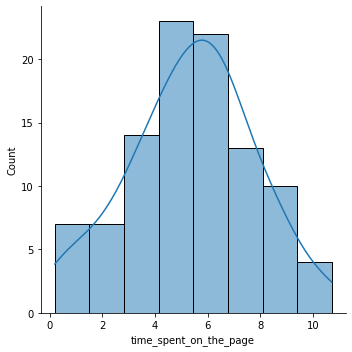

In [9]:
# plot the time_spent_on_the_page variable along with distribution estimation
sns.displot(data = df, x = 'time_spent_on_the_page', kde = True);

Plotting the distribution of the `time_spent_on_the_page` variable reveals a normal distribution. All following analysis on this variable will assume normality.

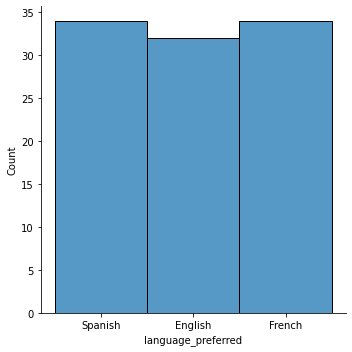

In [10]:
sns.displot(data = df, x = 'language_preferred');

Plotting the count of the `language_preferred` variable reveals a uniform distribution. Any further analysis on this variable will assume this distribution.

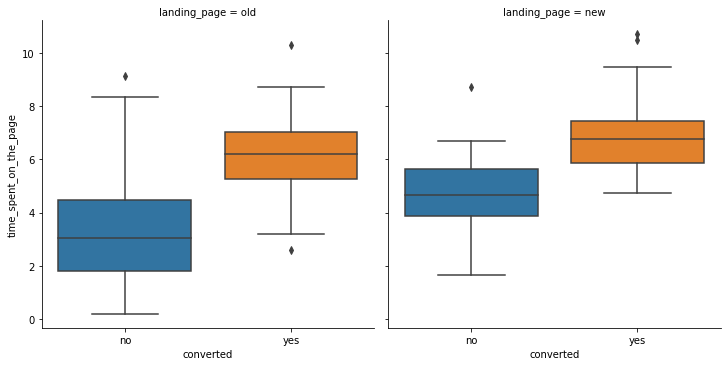

In [11]:
sns.catplot(data = df, x = 'converted', y = 'time_spent_on_the_page', col = 'landing_page', kind = 'box');

Plotting the `time_spent_on_the_page` vs. `converted` variables and separated by `group` reveals some interesting results.
These are merely observations and need explored further to determine statistical significance.
<ul>
    <li>Users who spend more time on the page are more likely to convert, independent of which group.</li>
    <li>The treatment group appears to have a higher conversion rate.</li>
    <li>The treatment group also appears to increase the time a user spends on a page, regardless if they converted or not.</li>
</ul>

### 2. Do the users spend more time on the new landing page than the old landing page?

Let $\mu_1, \mu_2$ be the mean time spent on the page for the control (old page) and treatment (new page) groups respectively.

Null hypothesis:

>$H_0:\mu_1=\mu_2$

Alternate hypothesis:

>$H_a:\mu_1<\mu_2$

The confidence level for all tests is 95% ($\alpha$ = 0.05)

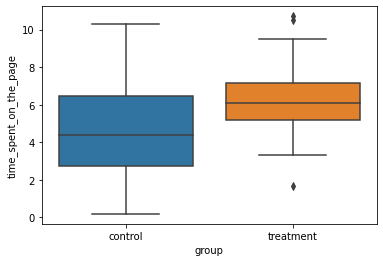

In [12]:
# create separate dataframes for the control and treatment groups.
# landing page and groups are synonymous
ctrl_group = df[df['group'] == 'control']
treat_group = df[df['group'] == 'treatment']

#plot the time sorted by groups
sns.boxplot(data = df, x = 'group', y = 'time_spent_on_the_page');

Based on the box plot, it would appear that the treatment group spent more time on the page than the control group did. However, this needs the appropriate test in order to state that claim with any statistical significance. 

In [13]:
# determine the average time spent on the page based on the groups and save to a variable.
ctrl_xbar = ctrl_group['time_spent_on_the_page'].mean()
treat_xbar = treat_group['time_spent_on_the_page'].mean()

#determine the sample variance 
ctrl_sigma = ctrl_group['time_spent_on_the_page'].std()
treat_sigma = treat_group['time_spent_on_the_page'].std()

#print the results
print(f'The average time spent on the page for the Control group is {round(ctrl_xbar, 2)} with standard deviation of {round(ctrl_sigma, 2)}')
print(f'The average time spent on the page for the Treatment group is {round(treat_xbar, 2)} with standard deviataion of {round(treat_sigma, 2)}')

The average time spent on the page for the Control group is 4.53 with standard deviation of 2.58
The average time spent on the page for the Treatment group is 6.22 with standard deviataion of 1.82


Based on the above analysis, we can assume the `time_spent_on_the_page` variable follows a normal distribution. Because of this, we will use the `norm` library from scipy.stats. Since these populations we're comparing are independent, normally distributed, and have unequal standard deviations, we use a 2-sample, independent T-test to compare the data. 

To determine if the treatment group is spending MORE time, we must do a one-sided test.

In [14]:
# import the appropriate packages for the desired test
from scipy.stats import norm, ttest_ind

In [15]:
# Calculate and extract the test statistic and p value from the test
test_stat, p_value = ttest_ind(ctrl_group['time_spent_on_the_page'], treat_group['time_spent_on_the_page'], equal_var = False, alternative = 'less')
print(f'The p-value of the t-test is: {round(p_value, 5)}')

The p-value of the t-test is: 0.00014


**Based on the above analysis, we reject the null-hypothesis. This concludes that we have enough statistical evidence to say that users spend more time on the new page, on average.**

### 3. Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?

$p_1$ and $p_2$ are the conversion rates of the old and new landing pages, respectively.

Null Hypothesis:

>$H_0:p_1 =p_2$

Alternate hypothesis:

>$H_a:p_1 < p_2$

The confidence level for all test is 95% ($\alpha$ = 0.05)

In [16]:
# Create filter variables to keep the code clean
ctrl_converted = ctrl_group['converted'] == 'yes'
treat_converted = treat_group['converted'] == 'yes'

# Calculate the number of converted and total samples
ctrl_nconverted = ctrl_group[ctrl_converted]['user_id'].count()
ctrl_total = ctrl_group['user_id'].count()

treat_nconverted = treat_group[treat_converted]['user_id'].count()
treat_total = treat_group['user_id'].count()

# Print the results
print(f'The conversion rate for the control group is {ctrl_nconverted / ctrl_total} with {ctrl_nconverted} converted')
print(f'The conversion rate for the treatment group is {treat_nconverted / treat_total} with {treat_nconverted} converted')

The conversion rate for the control group is 0.42 with 21 converted
The conversion rate for the treatment group is 0.66 with 33 converted


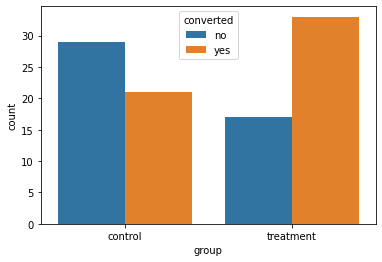

In [17]:
sns.countplot(data = df, x = 'group', hue = 'converted');

Since we are comparing the proportions of 2 different samples, we need to perform a 2 proportion z-test. But first we need to ensure the sample sizes and proportions are large enough to assume normality. 

>$np_1 = 50\cdot \frac{21}{50} =21 \geq 10\\
n(1-p_1) = 50 \cdot \frac{50-21}{50} =31 \geq 10 \\
np_2 = 50\cdot \frac{33}{50} =33 \geq 10\\
n(1-p_2) = 50 \cdot \frac{50-33}{50} =17 \geq 10 $

All conditions are met.


In [18]:
# import the appropriate package for the desired test
from statsmodels.stats.proportion import proportions_ztest

# calculate and extract the test statistic and p value from the test
test_stat, p_value = proportions_ztest(np.array([ctrl_nconverted, treat_nconverted]), np.array([ctrl_total, treat_total]))
print(f'The calculated p-value of the 2 proportions z-test is {round(p_value, 5)}')

The calculated p-value of the 2 proportions z-test is 0.01605


**Based on the analysis, there is enough statisitcal evidence to reject the null hypothesis. This confirms that based on the data, the conversion rate for the new landing page is greater than the old page with statistical significance.**

### 4. Does the converted status depend on the preferred language? [Hint: Create a contingency table using the pandas.crosstab() function]

Null hypothesis:

>$H_0:$ Converted status is independent of language preference.

Alternate hypothesis:

>$H_a:$ Converted status depends on language preference.

Confidence level of 95% ($\alpha$ = 0.05)

In [19]:
# create a variable for the conversion status vs the language preference and display the results
conv_lang = pd.crosstab(df['converted'], df['language_preferred'])
conv_lang

language_preferred,English,French,Spanish
converted,,,
no,11,19,16
yes,21,15,18


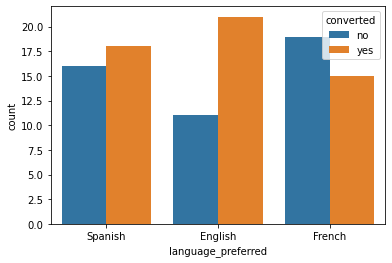

In [20]:
# Plot the count of the language preferred sorted by converted status
sns.countplot(data = df, x = 'language_preferred', hue = 'converted');

In [21]:
# import the appropriate package for the desired test
from scipy.stats import chi2_contingency

# find the p-value
chi, p_value, dof, expected = chi2_contingency(conv_lang)
print(f'The calculated p-value for the test is {round(p_value, 5)}')

The calculated p-value for the test is 0.21299


**Based on the analysis, we fail to reject the null hypothesis. We do not have enough evidence to determine any dependecy of the conversion status with respect to language preference.** 

### 5. Is the mean time spent on the new page same for the different language users?

<AxesSubplot:xlabel='language_preferred', ylabel='time_spent_on_the_page'>

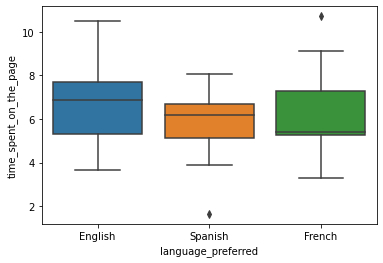

In [22]:
# plot the time spent on the new page sorted by preferred language.
sns.boxplot(data = treat_group, x = 'language_preferred', y = 'time_spent_on_the_page')

Let $\mu_1, \mu_2, \mu_3$ be the means of time spent for English, Spanish, and French respectively.

Null hypothesis:

>$H_0: \mu_1 = \mu_2 = \mu_3$

Alternative hypothesis:

>$H_a: $ At least one average time spent per language is different from the rest.

Confidence level of 95% ($\alpha$ = 0.05)

In [23]:
# Calculate and display the average time spent per language on the new site (treatment group)
treat_group.groupby('language_preferred')['time_spent_on_the_page'].mean()

language_preferred
English    6.663750
French     6.196471
Spanish    5.835294
Name: time_spent_on_the_page, dtype: float64

Since we're comparing the mean of 3 different groups we need to perform a one-way ANOVA test.
This test requires the normality and variance to be tested separately with a Shapiro-Wilk's test and Levene's test respectively.

The `time_spent_on_the_page` was determined to be normal for the entire test population during EDA, but since we're looking strictly at the users of the new page, we will continue with the necessary testing.

#### Shapiro-Wilk's test for Normality

Null hypothesis:

>$H_0:$ Time spent on the new page follows a normal distribution

Alternative hypothesis:

>$H_a:$ Time spent on the new page does not follow a normal distribution

Confidence level of 95% ($\alpha$ = 0.05)

In [24]:
# import the appropriate packages for the desired test
from scipy import stats

# find the p-value
w, p_value = stats.shapiro(treat_group['time_spent_on_the_page']) 
print('The p-value is', p_value)

The p-value is 0.8040016293525696


Based on the data, we fail to reject the null hypothesis, suggesting the data is normal. 

Now we must determine the equality of the population variances.

#### Levene’s test

Null hypothesis:

>$H_0$: All the population variances are equal

Alternative hypothesis:

>$H_a$: At least one variance is different from the rest

Confidence level of 95% ($\alpha$ = 0.05)

In [25]:
# import the appropriate packages for the desired test
from scipy.stats import levene

# calculate the test statistic and p value
test_stat, p_value = levene( treat_group['time_spent_on_the_page'][treat_group['language_preferred']=="English"], 
                             treat_group['time_spent_on_the_page'][treat_group['language_preferred']=="Spanish"],
                             treat_group['time_spent_on_the_page'][treat_group['language_preferred']=="French"])
# find the p-value
print('The p-value is', p_value)

The p-value is 0.46711357711340173


Based on the data, we fail to reject the null hypothesis, suggesting that the data supports that all groups exhibit similar variances.

With this test complete, the One-way ANOVA test can now be performed.

In [26]:
#Establish lists of time spent sorted by language
english_time = treat_group.loc[treat_group['language_preferred'] == 'English', 'time_spent_on_the_page']
spanish_time = treat_group.loc[treat_group['language_preferred'] == 'Spanish', 'time_spent_on_the_page']
french_time = treat_group.loc[treat_group['language_preferred'] == 'French', 'time_spent_on_the_page']

In [27]:
#import the appropriate packages for the desired test
from scipy.stats import f_oneway

# perform one-way anova test
test_stat, p_value = f_oneway(english_time, spanish_time, french_time)
print(f'The calculated p-value for the test is {round(p_value, 5)}')

The calculated p-value for the test is 0.43204


**Based on the data, we fail to reject the null hypothesis. This suggests that we do not have sufficient data to claim that the time spent on the new page is statistically different based on the preferred language of the user.**